In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Custom modules
from environment import EnvironmentState
from agents import LearningAgent
from data import DataGenerator

SEED = 42
np.random.seed(SEED)

In [2]:
n_levels = 10
horizon = 50
action_size = 10
n_episodes = 20

data = DataGenerator.generator("../data/AAPL.parquet", levels=n_levels).head(30000)

means = data[['Mid Price Movement', 'Market Spread', 'Book Imbalance', 'Signed Volume', 'Volatility', 'RSI']].mean()
means = np.concatenate([means.values, [0, 2.5, 2.5, 4.5]])

stds = data[['Mid Price Movement', 'Market Spread', 'Book Imbalance', 'Signed Volume', 'Volatility', 'RSI']].std()
stds = np.concatenate([stds.values, [1e4/3, 1.9, 1.9, 3]])

# Combine the two vectors in a matirx
std_values = np.vstack((means, stds)).T.astype(np.float32)

windows = []
for i in range(n_episodes):
    windows.append(data.iloc[i*(horizon+1):(i+1)*(horizon+1)])

In [3]:
min_values = data[['Mid Price Movement', 'Market Spread', 'Book Imbalance', 'Signed Volume', 'Volatility', 'RSI']].min().values
max_values = data[['Mid Price Movement', 'Market Spread', 'Book Imbalance', 'Signed Volume', 'Volatility', 'RSI']].max().values

min_values = np.concatenate([min_values, [-1e4, -1, -1, 0]])
max_values = np.concatenate([max_values, [1e4, 5, 5, 9]])

bounds = np.vstack((min_values, max_values)).T.astype(np.float32)

In [4]:
from approximators import TilingApproximatorMedium

q_approximator = TilingApproximatorMedium(
    bounds = bounds,
    n_tiles = 16,
    n_tilings = 64,
    # We can sample random shifts for each dimension
    shifts = np.random.uniform(0.8, 0.19, 10),
) 

In [5]:
from logger import Logger

logger = Logger()
agent = LearningAgent(
    action_size=action_size,
    q_value_approximator=q_approximator,
    epsilon=0.5,
    epsilon_decay=0.97,
    min_epsilon=0.01,
    gamma=0.99,
    logger=logger
)


from LOB import LOB

limit_order_book = LOB(data, n_levels)
env = EnvironmentState(limit_order_book, n_levels, horizon)

In [ ]:
rewards_train, losses_train, bankrolls_train = [], [], []
outstanding_orders = []
inventory = []

for episode in tqdm(range(6*n_episodes)):
    episode = episode % n_episodes
    env.data = windows[episode]
    rewards, losses, bankrolls = agent.train(env)

    # Track the evolution of the number of outstanding orders
    outstanding_orders.append(len(env.orders))
    inventory.append(env.inventory)

    rewards_train.append(rewards)
    losses_train.append(losses)
    bankrolls_train.append(bankrolls)

  0%|          | 0/120 [00:00<?, ?it/s]

In [7]:
rewards_train = np.array(rewards_train)
losses_train = np.array(losses_train)
bankrolls_train = np.array(bankrolls_train)
outstanding_orders = np.array(outstanding_orders)
inventory = np.array(inventory)

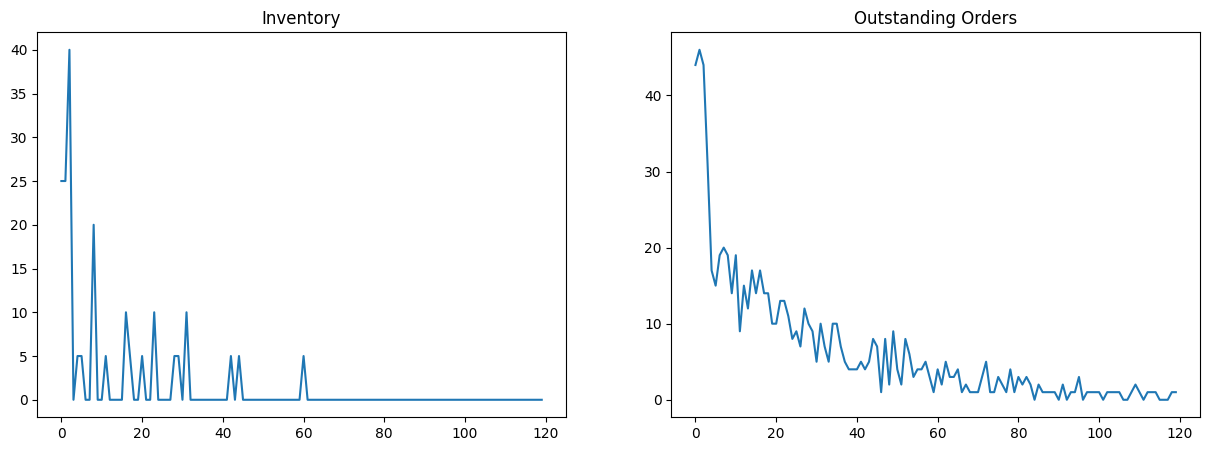

In [8]:
# Plot inventory and outstanding orders
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(inventory)
ax[0].set_title("Inventory")
ax[1].plot(outstanding_orders)
ax[1].set_title("Outstanding Orders")
plt.show()

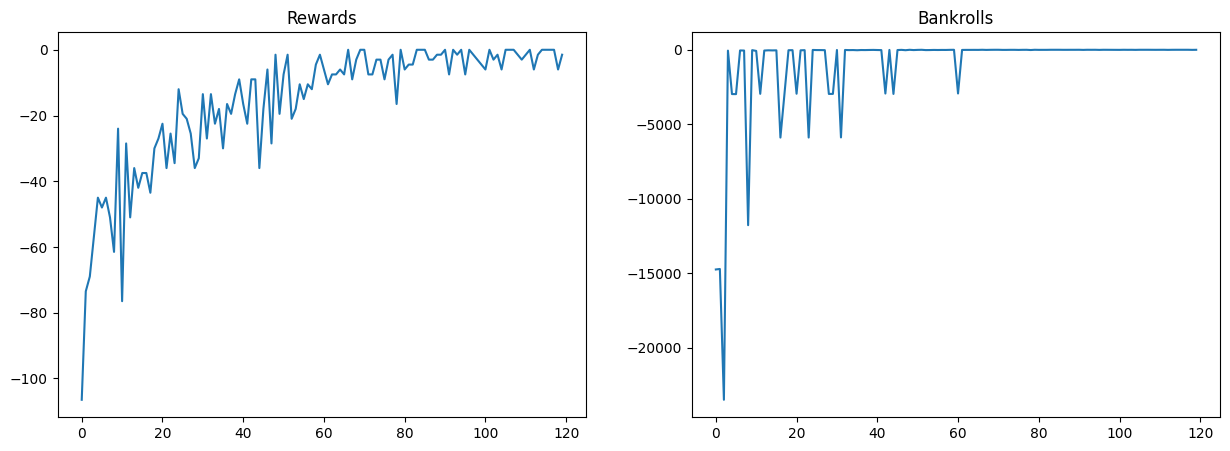

In [9]:
# plot rewards and bankrolls
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(rewards_train.cumsum(axis=1)[:, -1])
ax[0].set_title("Rewards")
ax[1].plot(bankrolls_train.cumsum(axis=1)[:, -1])
ax[1].set_title("Bankrolls")
plt.show()

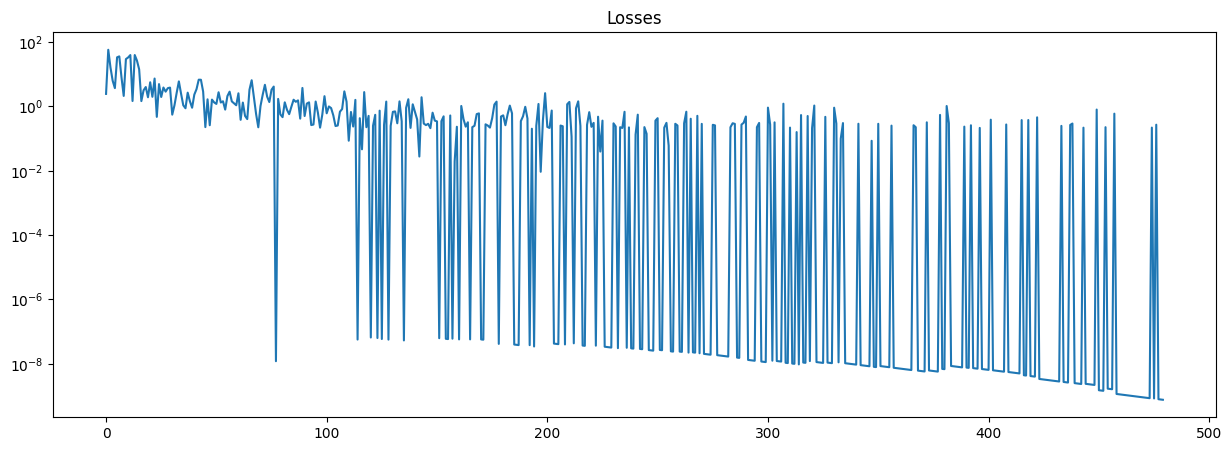

In [10]:
# Plot losses
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(losses_train.flatten())
# Plot SMA 5
# ax.plot(pd.Series(losses_train.mean(axis=1)).rolling(5).mean())
ax.set_title("Losses")
ax.set_yscale('log')
plt.show()